## Importation des packages

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import tree

from sklearn.preprocessing import scale
import operator
import sklearn.metrics as metrics
from sklearn.tree import DecisionTreeRegressor 

c:\Users\elelo\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\elelo\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\elelo\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## Chargement des données

In [2]:
enedis_IDF=pd.read_csv("Données/data_conso_moyenne/data_conso_6kva_IDF.csv",sep=",")
enedis_HDF=pd.read_csv("Données/data_conso_moyenne/data_conso_6kva_HDF.csv",sep=",")
enedis_PACA=pd.read_csv("Données/data_conso_moyenne/data_conso_6kva_PACA.csv",sep=",")

### On enlève les valeurs manquantes

enedis_IDF.dropna(inplace=True)
enedis_PACA.dropna(inplace=True)
enedis_HDF.dropna(inplace=True)

In [6]:
enedis_final=pd.read_csv("Données/enedis_filtered_6kva.csv",sep=",")

In [106]:
def decoupe(bdd_region):

    X=bdd_region[["tmoy"]]
    Y=bdd_region[["conso_totale_moyenne"]]
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)
    return (X,Y, X_train, X_test, Y_train, Y_test)

In [108]:
## Création des échantillons d'apprentissages et de tests

X_IDF,Y_IDF , X_train_IDF, X_test_IDF, Y_train_IDF, Y_test_IDF =decoupe(enedis_IDF)
X_PACA,Y_PACA , X_train_PACA, X_test_PACA, Y_train_PACA, Y_test_PACA =decoupe(enedis_PACA)
X_HDF,Y_HDF , X_train_HDF, X_test_HDF, Y_train_HDF, Y_test_HDF =decoupe(enedis_HDF)

## Construction BDD consommation par 30min

In [10]:
def bdd_30min(enedis_final,region):    
    conso_region=enedis_final[enedis_final["region_x"]==region]
    temperature=enedis_final[["date","region_x","tmoy"]]
    temperature_region=temperature[temperature.region_x==region]
    temperature_region.drop_duplicates(inplace=True)


    conso_region["heure"]=enedis_final["horodate"].apply(lambda x : x[11:16])

    nb_contrat=conso_region.nb_points_soutirage.mean()

    total_conso_region=conso_region.groupby(["date","heure"])["total_energie_soutiree_wh"].sum().reset_index() # pour chaque jour, on calcule la conso totale pour chaque heure
    total_conso_region["mois"]=total_conso_region["date"].apply(lambda x : x[5:7])
    total_conso_region["res_conso_moyenne"]=total_conso_region.total_energie_soutiree_wh/nb_contrat # conso moyenne soutirée par contrat pour chaque 30min

    total_conso_region=total_conso_region.merge(temperature_region,on="date",how="right")

    return(total_conso_region)

In [11]:
enedis_IDF_30=bdd_30min(enedis_final,"Île-de-France")

c:\Users\elelo\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
C:\Users\elelo\AppData\Local\Temp/ipykernel_20820/3971548881.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conso_region["heure"]=enedis_final["horodate"].apply(lambda x : x[11:16])


In [72]:
def decoupe_30min(bdd_region):

    X=bdd_region[["tmoy",'mois',"heure"]]
    Y=bdd_region[["res_conso_moyenne"]]
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)
    return (X,Y, X_train, X_test, Y_train, Y_test)

## Arbre CART

### Arbre de décision avec la température moyenne

In [27]:
from sklearn.model_selection import GridSearchCV
def caract_arbre(X_train, Y_train,X_test, Y_test):
    param_grid = {'max_depth':[3,4,5,6,7,8]}
    predictor= GridSearchCV(DecisionTreeRegressor(random_state=0),cv=10,param_grid=param_grid)
    predictor.fit(X_train,Y_train)
    print('Paramètre sélectionné:',predictor.best_params_)
    print('Score d\'apprentissage: ',predictor.score(X_train,Y_train))
    print('Score de test: ',predictor.score(X_test,Y_test))
    return(predictor.best_params_["max_depth"])

In [ ]:
#instanciation
model_DT = tree.DecisionTreeRegressor(max_depth=3,
                                           ccp_alpha=0.015,                                           )
#training
model_DT.fit(X_train_IDF,Y_train_IDF)
#Prédiction
prediction = model_DT.predict( X_test_IDF)
#calcule de précision
print( model_DT.score( X_test_IDF, Y_test_IDF))

In [111]:
caract_arbre(X_train_IDF,Y_train_IDF,X_test_IDF, Y_test_IDF)

Paramètre sélectionné: {'max_depth': 3}
Score d'apprentissage:  0.7621447822921474
Score de test:  0.6374292616245821


3

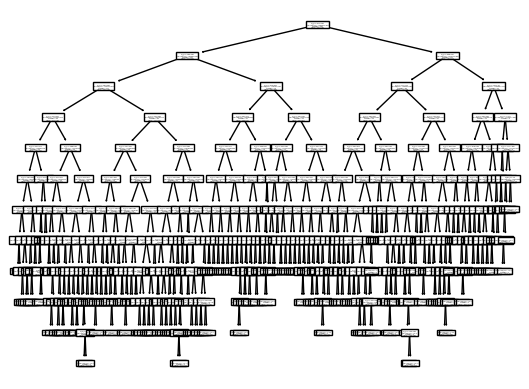

In [131]:
plot_tree(model_DT)
plt.show()

### Arbre de décision avec la variable date et température moyenne

In [28]:
from sklearn.preprocessing import OneHotEncoder

# Création d'un ensemble de données fictif avec une variable catégorielle
X =enedis_IDF["date"].to_numpy()
X=X.reshape(-1, 1)

# Création de l'objet OneHotEncoder
encoder = OneHotEncoder()

# Encodage des données avec OneHotEncoder
X_encoded = encoder.fit_transform(X)

# Affichage des données encodées

oneHot=pd.DataFrame(X_encoded.toarray(),index=enedis_IDF.index,columns=["jour_"+str(i+1) for i in range(len(X_encoded.toarray()))])
oneHot["indice"]=oneHot.index
enedis_IDF["indice"]=enedis_IDF.index
enedis_IDF=enedis_IDF.merge(oneHot,on="indice")
enedis_IDF

,date,total_energie_soutiree_wh,conso_totale_moyenne,region_x,tmoy,indice,jour_1,jour_2,jour_3,jour_4,...,jour_412,jour_413,jour_414,jour_415,jour_416,jour_417,jour_418,jour_419,jour_420,jour_421
0,2020-06-04,2.220684e+09,4336.626759,Île-de-France,14.51,0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-06-05,1.916970e+09,3743.523453,Île-de-France,14.20,1,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-06-06,2.419586e+09,4725.049313,Île-de-France,14.56,2,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-06-07,2.106218e+09,4113.094738,Île-de-France,14.22,3,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-06-08,1.892341e+09,3695.428178,Île-de-France,14.55,4,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416,2021-07-26,1.767541e+09,3451.713548,Île-de-France,20.13,417,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
417,2021-07-27,1.875844e+09,3663.212319,Île-de-France,18.15,418,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
418,2021-07-28,2.384563e+09,4656.656795,Île-de-France,19.23,419,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
419,2021-07-29,1.778174e+09,3472.479084,Île-de-France,18.27,420,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [135]:
def decoupedate (bdd_region):
    # Création d'un ensemble de données fictif avec une variable catégorielle
    Xdate =bdd_region["date"].to_numpy()
    Xdate=Xdate.reshape(-1, 1)

    # Création de l'objet OneHotEncoder
    encoder = OneHotEncoder()

    # Encodage des données avec OneHotEncoder
    X_encoded = encoder.fit_transform(Xdate)
    oneHot=pd.DataFrame(X_encoded.toarray(),index=bdd_region.index,columns=["jour_"+str(i+1) for i in range(len(X_encoded.toarray()))])
    oneHot["indice"]=oneHot.index
    bdd_region["indice"]=bdd_region.index
    bdd_region=bdd_region.merge(oneHot,on="indice")
    X=bdd_region.drop(["date","total_energie_soutiree_wh","region_x","indice"],axis=1)
    Y=bdd_region[["conso_totale_moyenne"]]
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)
    return (X,Y, X_train, X_test, Y_train, Y_test)

In [115]:
from sklearn.model_selection import GridSearchCV
def caract_arbre(X_train, Y_train,X_test, Y_test):
    param_grid = {'max_depth':[3,4,5,6,7,8]}
    predictor= GridSearchCV(DecisionTreeRegressor(random_state=0),cv=10,param_grid=param_grid)
    predictor.fit(X_train,Y_train)
    print('Paramètre sélectionné:',predictor.best_params_)
    print('Score d\'apprentissage: ',predictor.score(X_train,Y_train))
    print('Score de test: ',predictor.score(X_test,Y_test))
    return(predictor.best_params_["max_depth"])

In [34]:
## Création des échantillons d'apprentissages et de tests

X_IDF,Y_IDF , X_train_IDF, X_test_IDF, Y_train_IDF, Y_test_IDF =decoupedate(enedis_IDF)
X_PACA,Y_PACA , X_train_PACA, X_test_PACA, Y_train_PACA, Y_test_PACA =decoupedate(enedis_PACA)
X_HDF,Y_HDF , X_train_HDF, X_test_HDF, Y_train_HDF, Y_test_HDF =decoupedate(enedis_HDF)

NameError: name 'decoupedate' is not defined

In [117]:
from sklearn.model_selection import GridSearchCV
param_grid = {'max_depth':[3,4,5,6,7,8,9,10,11,12,13,14,17,20]}
predictor= GridSearchCV(DecisionTreeRegressor(random_state=0),cv=10,param_grid=param_grid)
predictor.fit(X_train_IDF,Y_train_IDF)
print('Paramètre sélectionné:',predictor.best_params_)
print('Score d\'apprentissage: ',predictor.score(X_train_IDF,Y_train_IDF))
print('Score de test: ',predictor.score(X_test_IDF,Y_test_IDF))

Paramètre sélectionné: {'max_depth': 7}
Score d'apprentissage:  0.9999584263761312
Score de test:  0.9993822959391319


In [32]:
def genere_arbre(X_train, Y_train,X_test, Y_test):
 #   max_depth_arbre=caract_arbre(X_train, Y_train,X_test, Y_test)
    #instanciation
    model_DT = tree.DecisionTreeRegressor(random_state=0,max_depth=4,ccp_alpha=0.015)
    #training
    model_DT.fit(X_train,Y_train)
    prediction = model_DT.predict( X_test)
    #calcule de précision
    print( model_DT.score( X_test, Y_test))
    plot_tree(model_DT)
    plt.show()
    return(model_DT)

In [33]:
arbre=genere_arbre(X_train_IDF, Y_train_IDF,X_test_IDF, Y_test_IDF)

NameError: name 'X_train_IDF' is not defined

## Arbre CART par 30min en fonction du mois et de la temperature

on importe les données qui sont one hot encodées :

In [3]:
enedis_IDF_30=pd.read_csv("Données/data_one_hot_encoded/data_one_hot_encoded_heure_mois_6kva_IDF.csv")

In [5]:
enedis_IDF_30[enedis_IDF_30.date=="2020-06-04"]

,date,heure,total_energie_soutiree_wh,mois,res_conso_moyenne,region_x,tmoy,indice,heure_1,heure_2,...,mois_3,mois_4,mois_5,mois_6,mois_7,mois_8,mois_9,mois_10,mois_11,mois_12
0,2020-06-04,00:00,55228733.0,6,107.852552,Île-de-France,14.51,0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-06-04,00:30,53298530.0,6,104.083186,Île-de-France,14.51,1,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-06-04,01:00,52609821.0,6,102.738252,Île-de-France,14.51,2,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-06-04,01:30,51404043.0,6,100.383567,Île-de-France,14.51,3,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-06-04,02:30,51462261.0,6,100.497258,Île-de-France,14.51,4,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2020-06-04,03:00,52781156.0,6,103.072841,Île-de-France,14.51,5,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2020-06-04,03:30,54709600.0,6,106.838772,Île-de-France,14.51,6,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2020-06-04,05:30,83065768.0,6,162.213663,Île-de-France,14.51,7,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8,2020-06-04,06:30,97027928.0,6,189.479445,Île-de-France,14.51,8,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9,2020-06-04,07:00,99661942.0,6,194.623238,Île-de-France,14.51,9,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
enedis_IDF_30.dropna(inplace=True)

In [50]:
def decoupedata_30min(bdd_region):


    X=bdd_region.drop(["heure","mois","date","total_energie_soutiree_wh","region_x","res_conso_moyenne","indice"],axis=1)
    Y=bdd_region[["res_conso_moyenne"]]
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)
    return (X,Y, X_train, X_test, Y_train, Y_test)

In [56]:
X_IDF_30

,tmoy,heure_1,heure_2,heure_3,heure_4,heure_5,heure_6,heure_7,heure_8,heure_9,...,mois_3,mois_4,mois_5,mois_6,mois_7,mois_8,mois_9,mois_10,mois_11,mois_12
0,14.51,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,14.51,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,14.51,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,14.51,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,14.51,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10251,18.68,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
10252,18.68,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
10253,18.68,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
10254,18.68,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [51]:
## Création des échantillons d'apprentissages et de tests

X_IDF_30,Y_IDF_30 , X_train_IDF_30, X_test_IDF_30, Y_train_IDF_30, Y_test_IDF_30 =decoupedata_30min(enedis_IDF_30)
#X_PACA_30,Y_PACA_30 , X_train_PACA_30, X_test_PACA_30, Y_train_PACA_30, Y_test_PACA_30 =decoupe_30min(enedis_PACA)
#X_HDF_30,Y_HDF_30 , X_train_HDF_30, X_test_HDF_30, Y_train_HDF_30, Y_test_HDF_30 =decoupe_30min(enedis_HDF)

In [55]:
caract_arbre(X_train_IDF_30,  Y_train_IDF_30,X_test_IDF_30,Y_test_IDF_30)

Paramètre sélectionné: {'max_depth': 8}
Score d'apprentissage:  0.7350264565760949
Score de test:  0.7263033448670952


8

0.6625265261928486


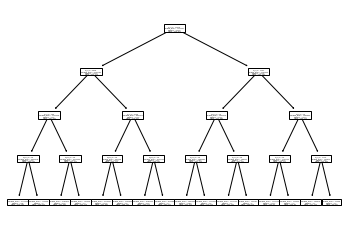

In [54]:
arbre=genere_arbre(X_train_IDF_30,  Y_train_IDF_30,X_test_IDF_30,Y_test_IDF_30)